# Лабораторная работа 5

Выполнили:
* Полежаева Евгения
* Солодкая Мария

## Измерение сходства узлов на основе представления графа

В графовых нейронных сетях (Graph Neural Networks, GNN) одним из важных аспектов является измерение сходства между узлами графа.

Node Similarity представляет собой меру близости или похожести между двумя узлами графа. Измерение сходства узлов основывается на их представлениях в графе.
Схожесть узлов (Node Similarity) в графовых сетях представляет собой меру близости или похожести между двумя узлами графа. Измерение сходства узлов основывается на их представлениях в графе. Это понятие играет важную роль в анализе графов, так как позволяет выявлять связи и паттерны между узлами.

Когда речь идет о измерении схожести узлов в графовых сетях, можно использовать различные метрики. Три такие распространенные метрики — это Косинусная схожесть (Cosine Similarity), Манхэттенское расстояние (Manhattan Distance) и Евклидово расстояние (Euclidean Distance).


### Примеры метрик схожести узлов:

**Косинусная схожесть** (Cosine Similarity):


> Измеряет угол между векторами признаков узлов в графе, представляя их как многомерные векторы.

> $Cosine(A, B) = (Σ (A_i * B_i)) / (\sqrt(Σ A_i^2) * \sqrt(Σ B_i^2)), где A_i и B_i$ - значения признаков узлов.

**Манхэттенское расстояние** (Manhattan Distance):

> Измеряет сумму абсолютной разницы между соответствующими координатами узлов на графе.

> $Manh(A, B) = Σ |A_i - B_i|, где A_i и B_i$ - координаты узлов по каждой из размерностей.

**Евклидово расстояние** (Euclidean Distance):


> Измеряет расстояние между двумя узлами в графе, представляя их как точки в пространстве.

> $Euclid(A, B) = sqrt(Σ (A_i - B_i)^2), где A_i и B_i$ - координаты узлов по каждой из размерностей.




Использование этих метрик расстояния позволяет оценить геометрическое расположение узлов в графе.













### Установка зависимостей


Устанавливаем необходимые для работы зависимости

In [1]:
!pip install pykeen networkx matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.3/739.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 26.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.1 MB/s eta 0:00:00
  Created wheel for rexmex: filename=rexmex-0.1.3-py3-none-any.whl size=19952 sha256=6706106d7131b20270356683d47c44da3d15448af744b586b439d9e29c3e8396
  Stored in directory: /root/.cache/pip/wheels/13/31/9d/51fb64454e6012bc88dd72b57609646432e478ba35772736d6
Successfully built rexmex


Далее, импортируем необходимых модулей

In [2]:
import torch
import pykeen
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline
from sklearn.neighbors import NearestNeighbors
from pykeen.evaluation import RankBasedEvaluator
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

INFO:pykeen.utils:Using opt_einsum


Здесь мы устанавливаем необходимые библиотеки и импортируем модули, которые будут использоваться в лабораторной работе.

## Взаимодействие с графовым датасетом и описание данных

В данной работе мы будем использовать графовый датасет [DBpedia50](https://arxiv.org/abs/1711.03438), предоставляющий собой выборку менее 50 тысяч сущностей из графа dbpedia.


Мы импортируем модуль datasets из Pykeen для работы с графовыми датасетами.

In [3]:
from pykeen.datasets import DBpedia50

Загружаем графовый датасет DBpedia50 из Pykeen. В результате выполнения этой команды будет создан объект, представляющий графовый датасет.

In [4]:
# Загрузка графового датасета DBpedia50
dbpedia_dataset = DBpedia50()

Мы можем вывести описание датасета, чтобы получить информацию о количестве сущностей, отношений и других характеристиках.

In [5]:
# Просмотр описания датасета
print(dbpedia_dataset)

DBpedia50(training_path="/root/.data/pykeen/datasets/dbpedia50/train.txt", testing_path="/root/.data/pykeen/datasets/dbpedia50/test.txt", validation_path="/root/.data/pykeen/datasets/dbpedia50/valid.txt")


## Обучение модели


Использеум pipeline() предоставляемый пакетом pykeen для обучения модели, в качестве аргументов указываем тип модели, набор данных, количество эпох обучения и устройство на котором проводится обучений

Проверяем наличие GPU устройства и вызываем функцию pipeline(), которая запускает процесс обучения модели, тестирования и валидации.

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Запускаем пайплайн обучения модели, в этот раз использем модель [ComplEx](https://pykeen.readthedocs.io/en/stable/api/pykeen.models.ComplEx.html)

In [ ]:
# Задаем параметры для pipeline
pipeline_results = pipeline(
    model="ComplEx",
    dataset=dbpedia_dataset,
    training_kwargs=dict(num_epochs=100),
    device=device
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=256.


Evaluating on cuda:0:   0%|          | 0.00/2.10k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.41s seconds



В PyKEEN, функция plot_losses используется для визуализации изменения значений функции потерь во времени (по эпохам) в процессе обучения модели. Эта функция часто используется для мониторинга производительности модели во время тренировки и может быть полезной для оценки, насколько хорошо модель учится на обучающем наборе данных.


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

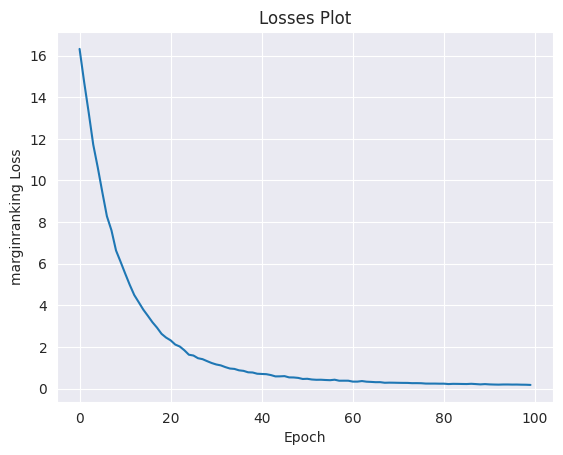

In [ ]:
# Обученная модель хранится в pipeline_results
model = pipeline_results.model

#plot loss
pipeline_results.plot_losses()

## Метрики оценки работы модели

В PyKEEN пакет metrics предоставляет реализацию различных метрик, которые могут быть использованы для оценки качества работы моделей знаний (knowledge graph embedding models). Эти метрики позволяют оценивать, насколько хорошо модель справляется с предсказанием троек в графе знаний.

Некоторые из основных метрик, доступных в пакете metrics:

*   Rank-based Metrics - которые измеряют позицию верного ответа (положительной тройки) в отсортированном списке всех возможных троек
*   Top-K Metrics - которые оценивают качество предсказаний в топ-K результатах.
*   Clustering Metrics - которые измеряют качество кластеризации.

Рассчитаем некоторые из них далее.

In [ ]:
# Создаем evaluator объект
evaluator = RankBasedEvaluator()

# Оценить работу модели
metrics = evaluator.evaluate(pipeline_results.model, dbpedia_dataset.testing.mapped_triples,
                             additional_filter_triples=[dbpedia_dataset.training.mapped_triples,
                                                        dbpedia_dataset.validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=256.


Evaluating on cuda:0:   0%|          | 0.00/2.10k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.46s seconds


Hits@1: 0.002386634844868735
Hits@3: 0.0042959427207637235
Hits@5: 0.0042959427207637235
Hits@10: 0.005727923627684964
Mean Reciprocal Rank: 0.004279877990484238


## Получение представлений узлов

После того как модель обучена, мы можем полчить представления узлов и отношений из результатов работы пайплайна.

In [ ]:
node_embeddings = pipeline_results.model.entity_representations

embedding_matrix = node_embeddings[0]._embeddings.weight.data

# Конвертируем матрицу весов в NumPy array
embedding_numpy = embedding_matrix.cpu().numpy()

Мы извлекаем представления узлов из обученной модели. В этом контексте, представления узлов - это векторы, представляющие сущности в графе.


Далее извлечем лейблы для сущнойстей и визуализируем некоторые из сущностей на плоскости.

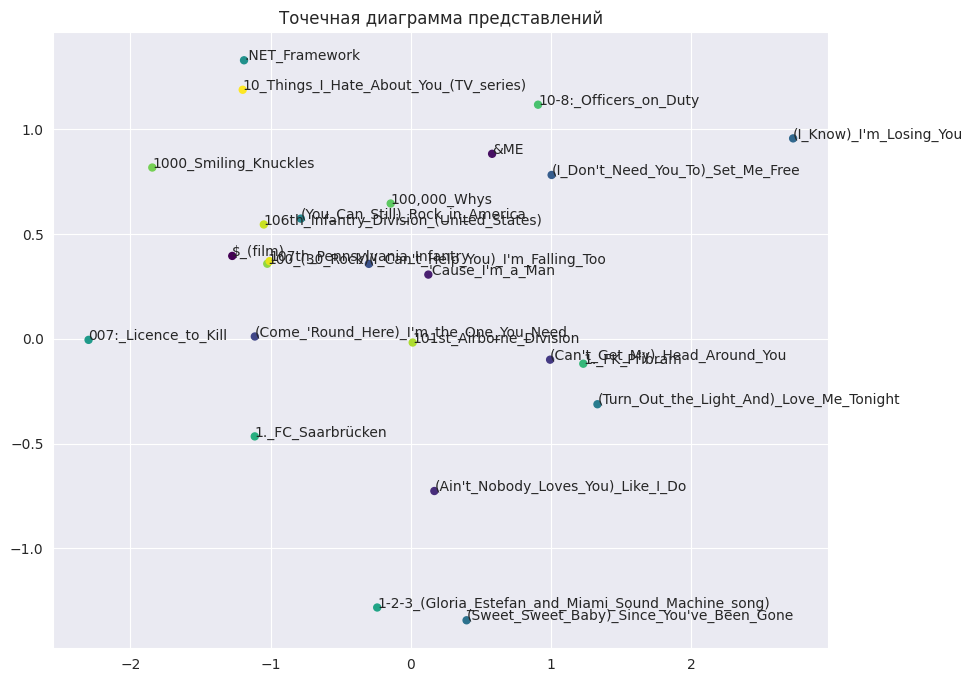

In [ ]:
#Сохраняем названия сущностей в отдельной переменной
id_to_lable = list(dbpedia_dataset.testing.entity_id_to_label.values())

def visualize_embeddings(embeddings, labels):
    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=np.arange(len(labels)), cmap='viridis', s=25)

    # Добавляем лейблы к точкаи на графике
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), alpha=1)

    plt.title('Точечная диаграмма представлений')
    plt.show()

#Количество точек которые необходимо отобразить на графике
number = 25

visualize_embeddings(embedding_numpy[:number], id_to_lable[:number])

Мы используем NetworkX и Matplotlib для визуализации представлений узлов на графе. Каждая сущность представлена точкой в двумерном пространстве, и близкие точки соответствуют похожим узлам в графе.


## Измерение Node Similarity

Добавим код для измерения близости узлов на основе представлений. Расчитаем близость между несколькими случайными узлами. Используем для этого косинусную схожесть, манхэттенское и евклидово расстояние. Визуализируем полученные результаты как матрицу близости.


[[ 0.       27.38056  27.8013   26.633953]
 [27.38056   0.       26.818464 27.793045]
 [27.8013   26.818464  0.       27.937939]
 [26.633953 27.793045 27.937939  0.      ]]


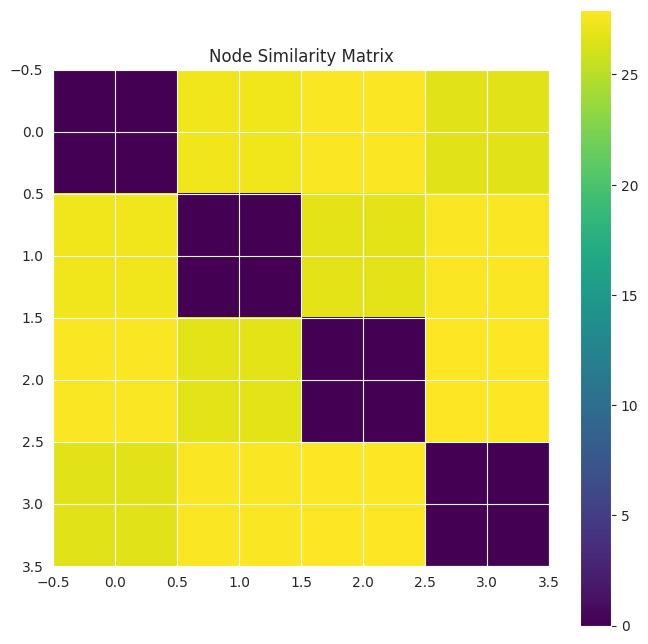

[[ 1.0000002  -0.00114274 -0.02810511  0.05775075]
 [-0.00114274  0.99999994  0.02703285 -0.04347607]
 [-0.02810511  0.02703285  1.         -0.05020501]
 [ 0.05775075 -0.04347607 -0.05020501  1.0000001 ]]


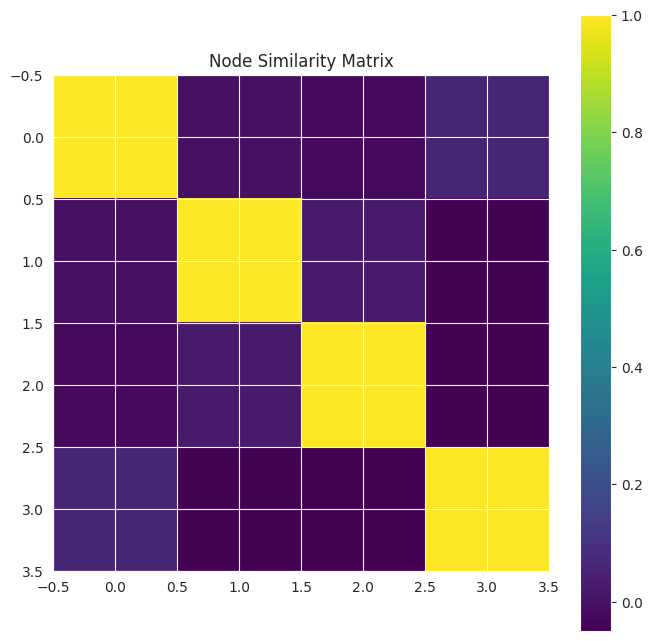

[[  0.         434.84767865 439.82896452 426.80231465]
 [434.84767865   0.         428.08948512 439.39115979]
 [439.82896452 428.08948512   0.         452.71747357]
 [426.80231465 439.39115979 452.71747357   0.        ]]


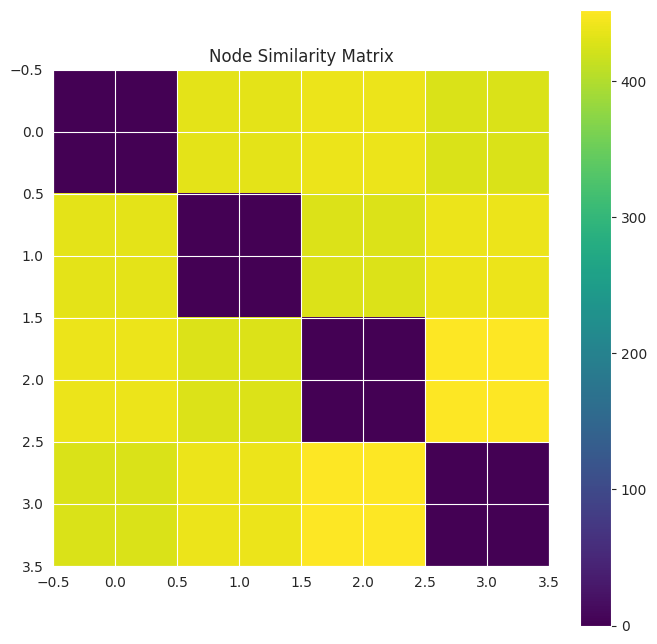

In [ ]:
def diplay_matrix(similarity_matrix):
  # Визуализация матрицы близости
  plt.figure(figsize=(8, 8))
  plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
  plt.colorbar()
  plt.title('Node Similarity Matrix')
  plt.show()


# Рассчет близости между узлами
methods = [euclidean_distances,cosine_similarity,manhattan_distances]
#Узлы
nodes = [embedding_numpy[1324],embedding_numpy[12240],embedding_numpy[15386],embedding_numpy[17242]]
for method in methods:
  similarity_matrix = method(nodes)
  print(similarity_matrix)
  diplay_matrix(similarity_matrix)

Этот код использует euclidean_distances,cosine_similarity и manhattan_distances из scikit-learn для вычисления матрицы близости между узлами на основе их представлений. Затем мы визуализируем эту матрицу для наглядного представления Node Similarity.

## Поиск соседей узла
Одной из задач где используется схожесть узлов является задача поиска ближайших соседей конкретного узла в графе.
Рассмотрии применение NearestNeighbors на созданных представлениях с использованием только что рассмотренных методов рассчета близости.

In [ ]:
# Выбираем случайный узел
random_node_index = 1324
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[ 0.       24.62825  24.725721 24.796942]]
Индексы:[[ 1324   315 13669 22266]]
Ближайшие соседи узла Alphonse_J._Jackson: ['Alphonse_J._Jackson', '3000_Miles_to_Graceland', 'Marek_Bakoš', 'Timo_Schultz'] 

Метрика:cosine
Дистанции:[[0.         0.81139016 0.81366825 0.8152564 ]]
Индексы:[[ 1324 22936 15424 23388]]
Ближайшие соседи узла Alphonse_J._Jackson: ['Alphonse_J._Jackson', 'University_of_Warsaw', 'Newcastle_University', 'Vítězslav_Mooc'] 

Метрика:manhattan
Дистанции:[[  0.         390.05545044 392.27087402 392.6619873 ]]
Индексы:[[ 1324   315 15424 22976]]
Ближайшие соседи узла Alphonse_J._Jackson: ['Alphonse_J._Jackson', '3000_Miles_to_Graceland', 'Newcastle_University', 'Urmuz'] 



In [ ]:
# Еще один узел
random_node_index = 5358
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[ 0.       24.680536 24.730635 24.751364]]
Индексы:[[ 5358  2195 13686  6899]]
Ближайшие соседи узла Dave_Krusen: ['Dave_Krusen', 'Aye_Tha_Aung', 'Mari_Hamada', 'Evert_V._Snedecker'] 

Метрика:cosine
Дистанции:[[1.1920929e-07 7.8217143e-01 7.8847063e-01 7.8907931e-01]]
Индексы:[[ 5358 16949 21979 20625]]
Ближайшие соседи узла Dave_Krusen: ['Dave_Krusen', 'Pieter_Nooten', 'The_West_Wing', 'Syed_Ahmed_(politician)'] 

Метрика:manhattan
Дистанции:[[  0.         386.62069702 387.31570435 389.57955933]]
Индексы:[[ 5358  2195 16949  4618]]
Ближайшие соседи узла Dave_Krusen: ['Dave_Krusen', 'Aye_Tha_Aung', 'Pieter_Nooten', 'Coliseum_(band)'] 



Этот код использует NearestNeighbors из scikit-learn для поиска ближайших соседей случайного узла в графе. Мы выводим метки ближайших соседей и дистанции до них.

**Node Similarity** и измерение сходства узлов на основе представления являются важными концепциями в графовых нейронных сетях. Эти меры помогают понять структуру графа и выявлять взаимосвязи между узлами. Визуализация представлений узлов может позволить наглядно представить этот процесс и лучше понять, как модель интерпретирует данные в графе.

В рамках этой работы мы рассмотрели что такое Node Similarity как ее рассчитать и как можноиспользовать. Однако, для получения более полного понимания вы можете выполнить следующие задания:

**Исследование влияния числа эпох обучения**
> Измените число эпох обучения в лабораторной работе и оцените, как это влияет на представления узлов и Node Similarity. Добавьте график, отображающий изменение метрики Node Similarity в зависимости от числа эпох.

**Сравнение различных моделей**
> Попробуйте другие модели графовых вложений, такие как HolE или DistMult, и сравните их эффективность в предсказании отношений и измерении Node Similarity.

**Анализ случайных узлов**
> Выберите несколько случайных узлов и проанализируйте их сходство с другими узлами. Обратите внимание на изменения при изменении числа эпох обучения или использовании различных моделей.


# Эксперимент с 10 эпохами обучения

In [ ]:
# Задаем параметры для pipeline
pipeline_results = pipeline(
    model="ComplEx",
    dataset=dbpedia_dataset,
    training_kwargs=dict(num_epochs=10),
    device=device
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=256.


Evaluating on cuda:0:   0%|          | 0.00/2.10k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.38s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

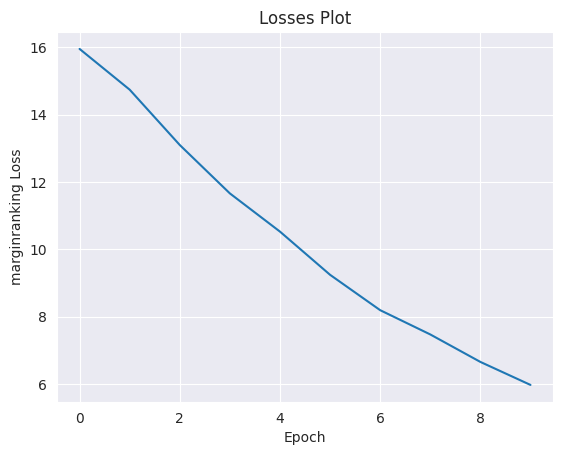

In [ ]:
# Обученная модель хранится в pipeline_results
model2 = pipeline_results.model

#plot loss
pipeline_results.plot_losses()

In [ ]:
# Создаем evaluator объект
evaluator = RankBasedEvaluator()

# Оценить работу модели
metrics = evaluator.evaluate(model2, dbpedia_dataset.testing.mapped_triples,
                             additional_filter_triples=[dbpedia_dataset.training.mapped_triples,
                                                        dbpedia_dataset.validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=256.


Evaluating on cuda:0:   0%|          | 0.00/2.10k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.38s seconds


Hits@1: 0.0007159904534606205
Hits@3: 0.001431980906921241
Hits@5: 0.001431980906921241
Hits@10: 0.001431980906921241
Mean Reciprocal Rank: 0.0013264021836221218


In [ ]:
node_embeddings = pipeline_results.model.entity_representations

embedding_matrix = node_embeddings[0]._embeddings.weight.data

# Конвертируем матрицу весов в NumPy array
embedding_numpy = embedding_matrix.cpu().numpy()

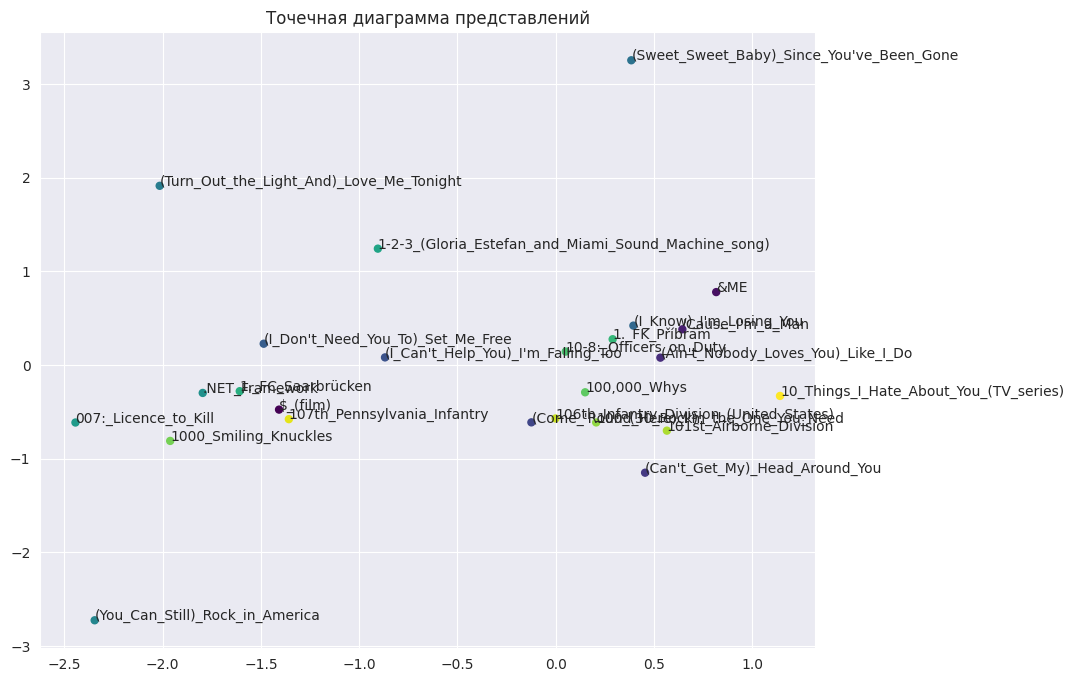

In [ ]:
#Сохраняем названия сущностей в отдельной переменной
id_to_lable = list(dbpedia_dataset.testing.entity_id_to_label.values())

def visualize_embeddings(embeddings, labels):
    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=np.arange(len(labels)), cmap='viridis', s=25)

    # Добавляем лейблы к точкаи на графике
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), alpha=1)

    plt.title('Точечная диаграмма представлений')
    plt.show()

#Количество точек которые необходимо отобразить на графике
number = 25

visualize_embeddings(embedding_numpy[:number], id_to_lable[:number])

In [ ]:
# Выбираем случайный узел
random_node_index = 1324
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[ 0.       24.006887 24.065033 24.36777 ]]
Индексы:[[ 1324 19850 19313  6355]]
Ближайшие соседи узла Alphonse_J._Jackson: ['Alphonse_J._Jackson', 'Sonet_Film', 'Seymour_Ginsburg', 'Edmilson_Carlos_Abel'] 

Метрика:cosine
Дистанции:[[1.1920929e-07 8.1803966e-01 8.1923974e-01 8.2488877e-01]]
Индексы:[[ 1324  3624  6355 19572]]
Ближайшие соседи узла Alphonse_J._Jackson: ['Alphonse_J._Jackson', 'California_Gold_Rush_(film)', 'Edmilson_Carlos_Abel', 'Silly_Symphony'] 

Метрика:manhattan
Дистанции:[[  0.         381.92349243 383.04882812 384.84820557]]
Индексы:[[ 1324 19313 19850  8073]]
Ближайшие соседи узла Alphonse_J._Jackson: ['Alphonse_J._Jackson', 'Seymour_Ginsburg', 'Sonet_Film', 'George_Murdock_(actor)'] 



In [ ]:
# Еще один узел
random_node_index = 5358
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[ 0.       25.185722 25.30505  25.410103]]
Индексы:[[ 5358 10833 16926 22041]]
Ближайшие соседи узла Dave_Krusen: ['Dave_Krusen', 'Joakim_Åhlund', 'Picture_This_Live', 'Theri_(film)'] 

Метрика:cosine
Дистанции:[[0.         0.80820745 0.8094493  0.81230336]]
Индексы:[[ 5358 16926  1694 12939]]
Ближайшие соседи узла Dave_Krusen: ['Dave_Krusen', 'Picture_This_Live', 'Anthony_Bancarel', 'Livistona'] 

Метрика:manhattan
Дистанции:[[  0.         400.35168457 401.97305298 404.38253784]]
Индексы:[[ 5358 10833 11984  1694]]
Ближайшие соседи узла Dave_Krusen: ['Dave_Krusen', 'Joakim_Åhlund', 'Kinda_Like_a_Big_Deal', 'Anthony_Bancarel'] 



# Эксперимент с моделью DistMult и 10 эпохами

In [7]:
from pykeen.datasets import DBpedia50

In [8]:
# Загрузка графового датасета DBpedia50
dbpedia_dataset = DBpedia50()

In [9]:
pipeline_results = pipeline(
    model="DistMult",
    dataset=dbpedia_dataset,
    training_kwargs=dict(num_epochs=10),
    device=device
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.


Evaluating on cuda:0:   0%|          | 0.00/2.10k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.87s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

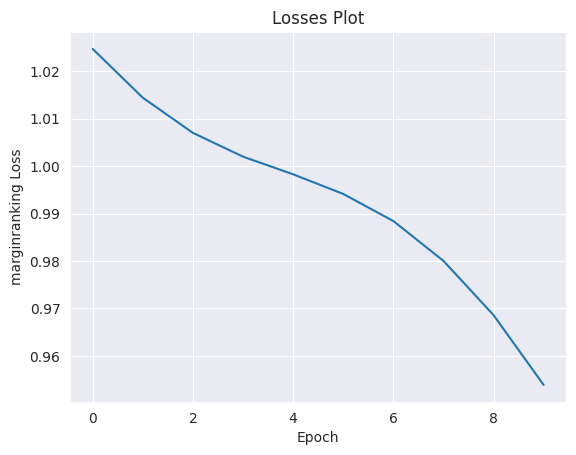

In [10]:
# Обученная модель хранится в pipeline_results
model3 = pipeline_results.model

#plot loss
pipeline_results.plot_losses()

In [11]:
# Создаем evaluator объект
evaluator = RankBasedEvaluator()

# Оценить работу модели
metrics = evaluator.evaluate(model3, dbpedia_dataset.testing.mapped_triples,
                             additional_filter_triples=[dbpedia_dataset.training.mapped_triples,
                                                        dbpedia_dataset.validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.


Evaluating on cuda:0:   0%|          | 0.00/2.10k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.85s seconds


Hits@1: 0.13770883054892602
Hits@3: 0.16563245823389022
Hits@5: 0.17255369928400954
Hits@10: 0.18281622911694512
Mean Reciprocal Rank: 0.1552809625864029


In [12]:
node_embeddings = pipeline_results.model.entity_representations

embedding_matrix = node_embeddings[0]._embeddings.weight.data

# Конвертируем матрицу весов в NumPy array
embedding_numpy = embedding_matrix.cpu().numpy()

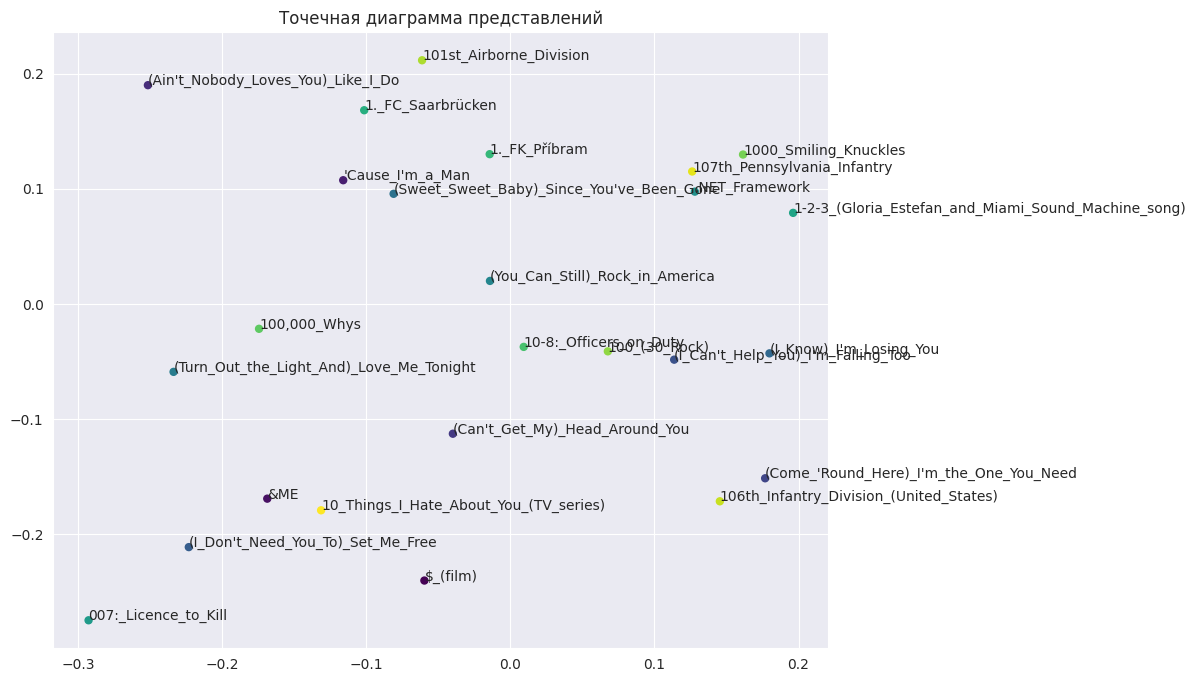

In [13]:
#Сохраняем названия сущностей в отдельной переменной
id_to_lable = list(dbpedia_dataset.testing.entity_id_to_label.values())

def visualize_embeddings(embeddings, labels):
    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=np.arange(len(labels)), cmap='viridis', s=25)

    # Добавляем лейблы к точкаи на графике
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), alpha=1)

    plt.title('Точечная диаграмма представлений')
    plt.show()

#Количество точек которые необходимо отобразить на графике
number = 25

visualize_embeddings(embedding_numpy[:number], id_to_lable[:number])

In [14]:
# Выбираем случайный узел
random_node_index = 1324
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[0.        0.9714405 0.9893418 1.0027806]]
Индексы:[[ 1324 22627 22596 13797]]
Ближайшие соседи узла Alphonse_J._Jackson: ['Alphonse_J._Jackson', 'Trudy_Grant', 'Trinidad_and_Tobago', 'Mark_Robson'] 

Метрика:cosine
Дистанции:[[0.         0.4718483  0.48939854 0.5027844 ]]
Индексы:[[ 1324 22627 22596 13797]]
Ближайшие соседи узла Alphonse_J._Jackson: ['Alphonse_J._Jackson', 'Trudy_Grant', 'Trinidad_and_Tobago', 'Mark_Robson'] 

Метрика:manhattan
Дистанции:[[0.         5.39052439 5.43548155 5.51871586]]
Индексы:[[ 1324 22627  8975 13797]]
Ближайшие соседи узла Alphonse_J._Jackson: ['Alphonse_J._Jackson', 'Trudy_Grant', 'Harlem_World_(group)', 'Mark_Robson'] 



In [15]:
# Еще один узел
random_node_index = 5358
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[0.         0.8808068  0.92706096 0.9983365 ]]
Индексы:[[ 5358 16597 11829 13514]]
Ближайшие соседи узла Dave_Krusen: ['Dave_Krusen', 'Pearl_Jam', 'Kenny_Brown_(footballer,_born_1967)', 'Mammoth_Records'] 

Метрика:cosine
Дистанции:[[5.9604645e-08 3.8791031e-01 4.2972094e-01 4.9833781e-01]]
Индексы:[[ 5358 16597 11829 13514]]
Ближайшие соседи узла Dave_Krusen: ['Dave_Krusen', 'Pearl_Jam', 'Kenny_Brown_(footballer,_born_1967)', 'Mammoth_Records'] 

Метрика:manhattan
Дистанции:[[0.         4.61665773 5.26072311 5.41285658]]
Индексы:[[ 5358 16597 11829 13514]]
Ближайшие соседи узла Dave_Krusen: ['Dave_Krusen', 'Pearl_Jam', 'Kenny_Brown_(footballer,_born_1967)', 'Mammoth_Records'] 

